In [74]:
print es[0].keys()
print es[0]['do_invert']

['id_bacc', 'pred_type', 'pred_name', 'id_pr', 'do_invert', 'id_roc']
True


In [68]:
import pickle

with open('/home/pierre/list', 'wb') as fp:
    pickle.dump(es, fp)

In [21]:
import os
import pickle
import itertools as itrt
import numpy as np
from sklearn import metrics
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
%matplotlib inline
from cycler import cycler
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams.update({'font.size': 15})
from matplotlib._png import read_png
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, \
    AnnotationBbox
import mpld3
mpld3.disable_notebook()
import h5py

import tempfile
def save_fig(fig, name):
    fig.savefig(tempfile.NamedTemporaryFile(prefix=name+'_', suffix='.png').name)

# color and linestyle cycle
colors_base = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.3', '0.5', '0.75', 'chartreuse', 'burlywood', 'aqua']
colors = [item for sublist in [colors_base]*len(colors_base) for item in sublist] # replicate and flatten

lnstyl = [[l] * len(colors_base) for l in ['-', '--', ':', '-.', '-', '--', ':', '-.','-', '--', ':','-', '--']] # replicate per color
lnstyl = [item for sublist in lnstyl for item in sublist] # flatten

plt.rc('axes', prop_cycle=(cycler('color', colors) + cycler('linestyle', lnstyl))) # define cycler

from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase

import nideep.eval.log_utils as lu

classnames =  ['alarm','baby','femaleSpeech','fire','crash','dog','engine','footsteps',\
               'knock','phone','piano','maleSpeech','femaleScream-maleScream']
num_azimuths = int(360/5)

print("Done importing")

Done importing


In [22]:
##########################################
# UTILS
##########################################

def find_nearest(arr, value):
    idx = np.abs(arr-value).argmin()
    return idx

def save_obj(fpath, obj):
    with open(fpath + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(fpath):
    with open(fpath + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_info(fpath):
    with open(fpath + '.info', 'rb') as f:
        lines = f.readlines()
        lines = [l.rstrip('\n') for l in lines]
        lines = [l.rstrip(',MLP') for l in lines]
        lines = [l.replace('MLP+', '') for l in lines]
        return lines
    
def moving_avg(x, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(x, window, 'valid')

##########################################
# IDENTIFICATION
##########################################

def eval_id_bacc(gt, preds, classnames=None):
    num_classes = gt.shape[-1]
    if classnames is None:
        classnames = range(num_classes)
    fig, ax2 = plt.subplots(1, 1)
    perf = []
    for cl in xrange(num_classes):
        # sensitivity == true positive rate (TPR) == hit rate == recall
        # specificity (SPC) or true negative rate (TNR) TN/N, equivalent to 1 - FPR
        gt_cl = gt[:, cl].ravel()
        preds_cl = preds[:, cl].ravel()
        fpr, sensitivity, thr = metrics.roc_curve(gt_cl, preds_cl,
                                                  drop_intermediate=True)
        spc = 1-fpr
        bacc_cl = 0.5*np.array(sensitivity)+0.5*np.array(spc)
        bacc_cl_max = bacc_cl.max()
        thr_bacc_cl_max = thr[bacc_cl.argmax()]
        ax2.plot(thr, bacc_cl,
                 color=colors_base[cl],
                 label=
                 '%d. %s, max(BAcc)=%.3f at thr=%.7f' % (cl,
                                                         classnames[cl],
                                                         bacc_cl_max,
                                                         thr_bacc_cl_max,
                                                        ))
        perf.append({'cl_id': cl, 'classname': classnames[cl],
                     'bacc_cl_max': bacc_cl_max,
                     'sensitivity_bacc_cl_max': sensitivity[bacc_cl.argmax()],
                     'specificity_bacc_cl_max': spc[bacc_cl.argmax()],
                     'thr_bacc_cl_max': thr_bacc_cl_max,
                     'num_points': len(gt_cl),
                     'num_pos': np.count_nonzero(gt_cl),
                     }) 
    ax2.set_xlim([-0.02, 1.02])
    ax2.set_ylim([-0.02, 1.02])
    ax2.set_title('Per-class balanced accuracy')
    ax2.set_xlabel('Classifier threshold')
    ax2.set_ylabel('Balanced accuracy')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    save_fig(fig, 'eval_id_bacc')
    return perf

def eval_id_pr(gt, preds, classnames=None,
               thr_select=[0.001, 0.01, 0.1, 0.5, 0.9, 0.999]):
    num_classes = gt.shape[-1]
    if classnames is None:
        classnames = range(num_classes)
    fig, ax = plt.subplots(1, 1)
    perf = []
    for cl in xrange(num_classes):
        gt_cl = gt[:, cl].ravel()
        preds_cl = preds[:, cl].ravel()
        precision, recall, thr = metrics.precision_recall_curve(gt_cl, preds_cl)
        pr_auc = metrics.auc(recall, precision)
        ax.plot(recall, precision,
                color=colors_base[cl],
                label='%d. %s (auc=%2f)' % (cl, classnames[cl],
                                            pr_auc,))
        if len(thr_select) > 0:
            fig_cl, ax_cl = plt.subplots(1, 1)
            ax_cl.plot(recall, precision,
                       color=colors_base[cl],
                       label='%d. %s (auc=%2f)' % (cl, classnames[cl],
                                                   pr_auc,))
            thr = np.array(thr)
            for thr_s in thr_select:
                thr_idx = find_nearest(thr, thr_s)
                ax_cl.scatter(recall[thr_idx], precision[thr_idx],
                            color=colors_base[cl])
                ax_cl.text(recall[thr_idx]*1.008, precision[thr_idx]*1.002,
                         '%f' % (thr[thr_idx],),
                         color=colors_base[cl],
                         size=10)
                ax_cl.set_xlabel('Recall')
                ax_cl.set_ylabel('Precision')
                ax_cl.set_title("%s precision-recall" % (classnames[cl],))
                ax_cl.set_xlim([-0.02,1.02])
                ax_cl.set_ylim([-0.02,1.02])
                ax_cl.legend(loc='lower right')
        perf.append({'cl_id': cl, 'classname': classnames[cl],
                     'pr_auc': pr_auc,
                     'num_points': len(gt_cl),
                     'num_pos': np.count_nonzero(gt_cl),
                     'precision': precision,
                     'recall': recall,
                     })
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title("Per-class precision-recall")
    ax.set_xlim([-0.02,1.02])
    ax.set_ylim([-0.02,1.02])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    save_fig(fig, 'eval_id_pr')
    return perf

def eval_id_roc(gt, preds, classnames=None,
                thr_select=[0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.999],
                do_plot=True):
    num_classes = gt.shape[-1]
    if classnames is None:
        classnames = range(num_classes)
    fig, ax = plt.subplots(1, 1)
    perf = []
    for cl in xrange(num_classes):
        gt_cl = gt[:, cl].ravel()
        preds_cl = preds[:, cl].ravel()
        fpr, tpr, thr = metrics.roc_curve(gt_cl, preds_cl,
                                          drop_intermediate=True)
        roc_auc = metrics.auc(fpr, tpr)
        if do_plot:
            ax.plot(fpr, tpr,
                    color=colors_base[cl],
                    label='%d. %s ROC (AUC=%2f)' % (cl, classnames[cl], roc_auc,))
            if len(thr_select) > 0:
                fig_cl, ax_cl = plt.subplots(1, 1)
                ax_cl.plot(fpr, tpr,
                         color=colors_base[cl],
                         label='%d. %s ROC (auc=%2f)' % (cl, classnames[cl], roc_auc,))
                thr = np.array(thr)
                for thr_s in thr_select:
                    thr_idx = find_nearest(thr, thr_s)
                    ax_cl.scatter(fpr[thr_idx], tpr[thr_idx],
                               color=colors_base[cl])
                    ax_cl.text(fpr[thr_idx]+0.01, tpr[thr_idx]-0.02,
                               '%f' % (thr[thr_idx],),
                               color=colors_base[cl],
                               size=10)
                ax_cl.set_xlabel('false positive rate (fall-out)')
                ax_cl.set_ylabel('true positive rate (sensitivity)')
                ax_cl.set_title("%s ROC" % (classnames[cl],))
                ax_cl.set_xlim([-0.02,1.02])
                ax_cl.set_ylim([-0.02,1.02])
                ax_cl.legend(loc='lower right')
        perf.append({'cl_id': cl, 'classname': classnames[cl],
                     'roc_auc': roc_auc})
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title("ROC")
    ax.set_xlim([-0.02,1.02])
    ax.set_ylim([-0.02,1.02])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    save_fig(fig, 'eval_id_roc')
    return perf

##########################################
# LOCALIZATION
##########################################

def eval_loc_bacc(gt, preds):
    locs = gt.shape[-1]
    loc_azimuth_value = np.linspace(-180, 180, locs, endpoint=False)
    radii = np.zeros(loc_azimuth_value.shape)
    perf = []
    for loc_idx in xrange(locs):
        gt_loc = gt[:, :, :, loc_idx].ravel()
        if len(preds.shape) == 3:
            pred_loc = preds[:, np.newaxis, :, loc_idx].ravel()
        else:
            pred_loc = preds[:, :, :, loc_idx].ravel()
        pred_loc.shape
        fpr, sensitivity, thr = metrics.roc_curve(gt_loc, pred_loc,
                                                  drop_intermediate=True)
        spc = 1-fpr
        bacc_cl = 0.5*np.array(sensitivity)+0.5*np.array(spc)
        radii[loc_idx] = bacc_cl.max()
        perf.append({'cl_id': loc_idx, 'classname': r'%s$^\circ$' % (loc_azimuth_value[loc_idx],),
                     'bacc_cl_max': radii[loc_idx],
                     'sensitivity_bacc_cl_max': sensitivity[bacc_cl.argmax()],
                     'specificity_bacc_cl_max': spc[bacc_cl.argmax()],
                     'thr_bacc_cl_max': thr[bacc_cl.argmax()],
                     'num_points': len(gt_loc),
                     'num_pos': np.count_nonzero(gt_loc),
                     }) 
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar')
    # repeat first value to complete the circle
    loc_azimuth_value = np.append(loc_azimuth_value, loc_azimuth_value[0])
    radii = np.append(radii, radii[0])
    ax.plot(np.deg2rad(loc_azimuth_value), radii, color='b', linewidth=2.)
    ax.set_rmax(1.0)
    ax.set_xticklabels([r'%s$^\circ$' % (tmp,) for tmp in ['0', '45', '90', '135', '180', '-135', '-90', '-45']])
    ax.set_theta_zero_location('N')  # Set zero to North
    ax.set_theta_direction(-1)  # -1: Theta increases in the clockwise direction
    ax.grid(b=True, which='both')
    ax.minorticks_on()
    ax.set_title('Per-azimuth max(BAcc)')
    head_img = read_png('/home/kashefy/src/caffe_pvt/head.png')
    imagebox = OffsetImage(1-head_img, zoom=0.4, cmap='Greys')
    ab = AnnotationBbox(imagebox, [0, 0],
                        xycoords='data',
                        pad=-0.1)
    ax.add_artist(ab)
    save_fig(fig, 'eval_loc_bacc')
    return perf

def eval_loc_bacc_cond(gt, preds, preds_id):
    locs = gt.shape[-1]-1
    loc_azimuth_value = np.linspace(-180, 180, locs, endpoint=False)
    radii = np.zeros(loc_azimuth_value.shape)
    perf = []
    for loc_idx in xrange(locs):
        gt_loc = gt[:, :, :, loc_idx].ravel()
        if len(preds.shape) == 3:
            pred_loc = preds[:, np.newaxis, :, loc_idx].ravel()
        else:
            pred_loc = preds[:, :, :, loc_idx].ravel()
        pred_loc = pred_loc * (1-preds_id.ravel())
        fpr, sensitivity, thr = metrics.roc_curve(gt_loc, pred_loc,
                                                  drop_intermediate=True)
        spc = 1-fpr
        bacc_cl = 0.5*np.array(sensitivity)+0.5*np.array(spc)
        radii[loc_idx] = bacc_cl.max()
        perf.append({'cl_id': loc_idx, 'classname': r'%s$^\circ$' % (loc_azimuth_value[loc_idx],),
                     'bacc_cl_max': radii[loc_idx],
                     'sensitivity_bacc_cl_max': sensitivity[bacc_cl.argmax()],
                     'specificity_bacc_cl_max': spc[bacc_cl.argmax()],
                     'thr_bacc_cl_max': thr[bacc_cl.argmax()],
                     'num_points': len(gt_loc),
                     'num_pos': np.count_nonzero(gt_loc),
                     }) 
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar')
    # repeat first value to complete the circle
    loc_azimuth_value = np.append(loc_azimuth_value, loc_azimuth_value[0])
    radii = np.append(radii, radii[0])
    ax.plot(np.deg2rad(loc_azimuth_value), radii, color='b', linewidth=2.)
    ax.set_rmax(1.0)
    ax.set_xticklabels([r'%s$^\circ$' % (tmp,) for tmp in ['0', '45', '90', '135', '180', '-135', '-90', '-45']])
    ax.set_theta_zero_location('N')  # Set zero to North
    ax.set_theta_direction(-1)  # -1: Theta increases in the clockwise direction
    ax.grid(b=True, which='both')
    ax.minorticks_on()
    ax.set_title('Per-azimuth max(BAcc|Identification)')
    head_img = read_png('/home/kashefy/src/caffe_pvt/head.png')
    imagebox = OffsetImage(1-head_img, zoom=0.4, cmap='Greys')
    ab = AnnotationBbox(imagebox, [0, 0],
                        xycoords='data',
                        pad=-0.1)
    ax.add_artist(ab)
    save_fig(fig, 'eval_loc_bacc_cond')
    return perf

def eval_loc_pr(gt, preds):    
    locs = gt.shape[-1]
    loc_azimuth_value = np.linspace(-180, 180, locs, endpoint=False)
    pr_auc_vals = np.zeros(loc_azimuth_value.shape)
    plt.figure()
    perf = []
    for loc_idx in xrange(locs):
        gt_loc = gt[:, :, :, loc_idx].ravel()
        if len(preds.shape) == 3:
            pred_loc = preds[:, np.newaxis, :, loc_idx].ravel()
        else:
            pred_loc = preds[:, :, :, loc_idx].ravel()
        precision, recall, _ = metrics.precision_recall_curve(gt_loc, pred_loc)
        pr_auc = metrics.auc(recall, precision)
        plt.plot(recall, precision,
                 'b-',
                 label='%d. (auc=%2f)' % (loc_azimuth_value[loc_idx], pr_auc,))
        pr_auc_vals[loc_idx] = pr_auc
        perf.append({'cl_id': loc_idx, 'classname': r'%s$^\circ$' % (loc_azimuth_value[loc_idx],),
                     'pr_auc': pr_auc,
                     'num_points': len(gt_loc),
                     'num_pos': np.count_nonzero(gt_loc),
                     })
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Per-azimuth precision-recall")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar')
    # repeat first value to complete the circle
    loc_azimuth_value = np.append(loc_azimuth_value, loc_azimuth_value[0])
    pr_auc_vals = np.append(pr_auc_vals, pr_auc_vals[0])
    ax.plot(np.deg2rad(loc_azimuth_value), pr_auc_vals, color='b', linewidth=2.)
    #ax.plot(np.deg2rad([45,90,180,-180,-45]), [0.1,0.2,0.3,0.4,0.5], color='r', linewidth=3.)
    ax.set_rmax(1.0)
    ax.set_xticklabels([r'%s$^\circ$' % (tmp,) for tmp in ['0', '45', '90', '135', '180', '-135', '-90', '-45']])
    ax.set_theta_zero_location('N')  # Set zero to North
    ax.set_theta_direction(-1)  # -1: Theta increases in the clockwise direction
    ax.grid(b=True, which='both')
    ax.minorticks_on()
    ax.set_title('Per-azimuth AUC(Precision-Recall)')
    head_img = read_png('/home/kashefy/src/caffe_pvt/head.png')
    imagebox = OffsetImage(1-head_img, zoom=0.4, cmap='Greys')
    ab = AnnotationBbox(imagebox, [0, 0],
                        xycoords='data',
                        pad=-0.1)
    ax.add_artist(ab)
    save_fig(fig, 'eval_loc_pr')
    return perf

##########################################
# EVAL SUMMARY
##########################################

def get_model_keys(h, key_label='label_id_loc'):

    model_keys = []
    for key in h.keys():
#         print('%s: %s' % (key, h[key].shape))
        if 'void' in key:
            model_keys.append({'pred_name' : key,
                               'pred_type' : 'id',
                               'do_invert' : True})
        elif 'bin' in key:
            model_keys.append({'pred_name' : key,
                               'pred_type' : 'loc',
                               'do_invert' : False})
        elif key != key_label and 'srcs' not in key.lower():
            model_keys.append({'pred_name' : key,
                               'pred_type' : 'id',
                               'do_invert' : True})
            model_keys.append({'pred_name' : key,
                               'pred_type' : 'loc',
                               'do_invert' : False})
    return model_keys
    
def eval_summary(fpath_infer, num_points=None, key_label='label_id_loc'):
    
    with h5py.File(fpath_infer, 'r') as h:
        if num_points is None:
            num_points = len(h[key_label])
        model_stats = get_model_keys(h, key_label=key_label)

        for m in model_stats:
            key_pred = m['pred_name']
            gt = h[key_label]
            pred = h[key_pred]
    #         print h.file, key_pred, pred.shape, m['pred_type']
            if m['pred_type'] == 'id':
                gt = np.squeeze(gt[:num_points,:,:,-1])
                # handle different prediction shapes
                if len(pred.shape) == 2:
                    if pred.shape[1] > len(classnames):
                        pred = pred[:num_points].reshape(num_points, 1, len(classnames), num_azimuths+1)
                    else:
                        pred = pred[:num_points].reshape(num_points, 1, len(classnames), 1)
                if len(pred.shape) == 4:
                    pred = np.squeeze(pred[:num_points,:,:,-1])
                if m['do_invert']:
                    gt = 1-gt
                    pred = 1-pred
                m['id_roc'] = eval_id_roc(gt, pred, classnames=classnames)
                m['id_bacc'] = eval_id_bacc(gt, pred, classnames=classnames)
                m['id_pr'] = eval_id_pr(gt, pred, classnames=classnames)
            elif m['pred_type'] == 'loc':
                gt = gt[:num_points,:,:,:-1] # no squeeze
                # handle different prediction shapes
                if len(pred.shape) == 2 and pred.shape[1] > num_azimuths:
                        pred = pred[:num_points].reshape(num_points, 1, len(classnames), num_azimuths+1)
                if len(pred.shape) == 4:
                    # exclude void bin if present
                    if pred.shape[-1] > num_azimuths:
                        pred_id = pred[:num_points,:,:,-1]
                        pred = pred[:num_points,:,:,:-1]
                        m['loc_bacc_cond'] = eval_loc_bacc_cond(gt, pred, pred_id)
                    else:
                        pred = pred[:num_points,:,:,:]
                m['loc_pr'] = eval_loc_pr(gt, pred)
                m['loc_bacc'] = eval_loc_bacc(gt, pred)
    return model_stats

def eval_summary_mixed(fpath_infer, num_points=None,
                       key_label='label_id_loc'):
    h = h5py.File(fpath_infer, 'r')
    if num_points is None:
        num_points = len(h[key_label])
    model_stats = get_model_keys(h, key_label=key_label)
    num_points_orig = num_points
    for m in model_stats:
        num_points = num_points_orig
        key_pred = m['pred_name']
        gt = h[key_label][:num_points,:,:,:-1]
        pred = h[key_pred][:num_points]
        source_count = np.sum(gt, axis=(1,2,3))
        mix_rows = np.where(source_count>1)[0]
        num_points = min(mix_rows.size, num_points)
        mix_rows = mix_rows[:num_points]
        gt = gt[mix_rows]
        pred = pred[mix_rows]
        if m['pred_type'] == 'id':
            # handle different prediction shapes
            gt = np.squeeze(gt[:num_points,:,:,-1])
            if len(pred.shape) == 2:
                if pred.shape[1] > len(classnames):
                    pred = pred[:num_points].reshape(num_points, 1, len(classnames), num_azimuths+1)
                else:
                    pred = pred[:num_points].reshape(num_points, 1, len(classnames), 1)
            if len(pred.shape) == 4:
                pred = np.squeeze(pred[:num_points,:,:,-1])
            if m['do_invert']:
                gt = 1-gt
                pred = 1-pred
            m['id_roc'] = eval_id_roc(gt, pred, classnames=classnames)
            m['id_bacc'] = eval_id_bacc(gt, pred, classnames=classnames)
            m['id_pr'] = eval_id_pr(gt, pred, classnames=classnames)
        elif m['pred_type'] == 'loc':
            gt = gt[:num_points,:,:,:-1] # no squeeze
            # handle different prediction shapes
            if len(pred.shape) == 2 and pred.shape[1] > num_azimuths:
                    pred = pred[:num_points].reshape(num_points, 1, len(classnames), num_azimuths+1)
            if len(pred.shape) == 4:
                # exclude void bin if present
                if pred.shape[-1] > num_azimuths:
                    pred = pred[:num_points,:,:,:-1]
                else:
                    pred = pred[:num_points,:,:,:]
            m['loc_pr'] = eval_loc_pr(gt, pred)
            m['loc_bacc'] = eval_loc_bacc(gt, pred)     
    return model_stats

In [ ]:
print es[1].keys()
print "Id classes par ROC AUC", [(x['classname'], x['roc_auc']) for x in sorted(es[0]['id_roc'], key=lambda x: x['roc_auc'], reverse=True)]

print "Id classes par balanced accuracy", [(x['classname'], x['bacc_cl_max']) for x in sorted(es[0]['id_bacc'], key=lambda x: x['bacc_cl_max'], reverse=True)]

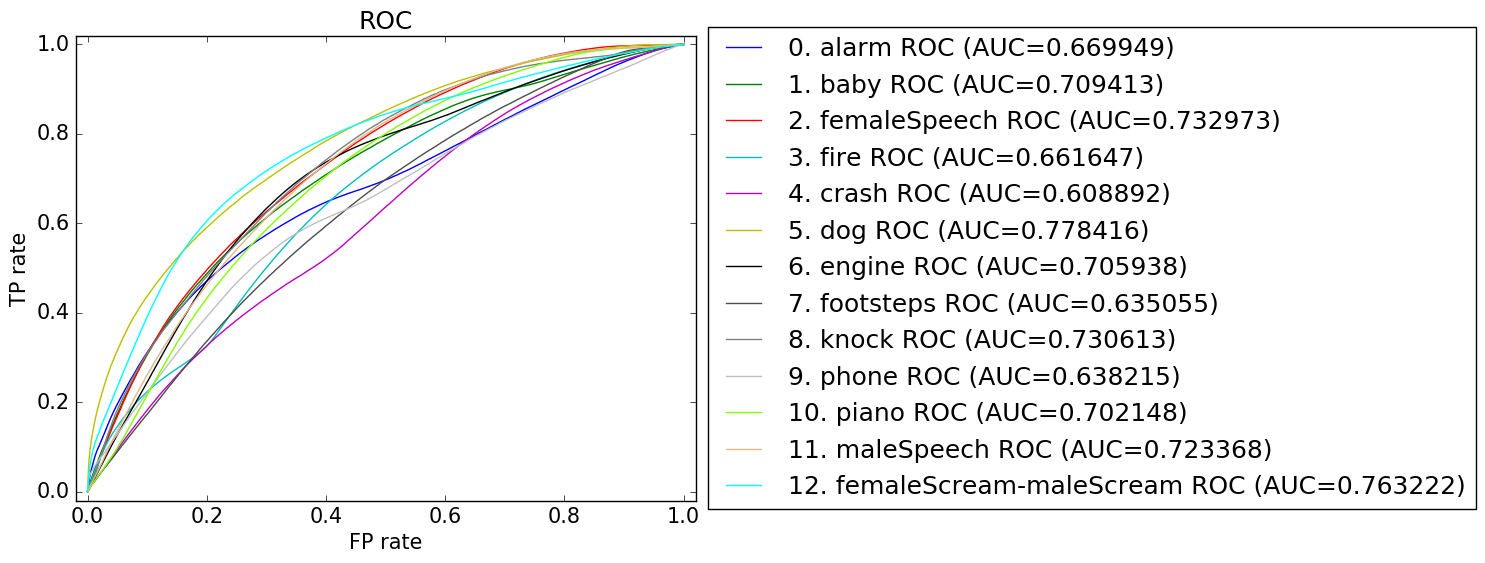

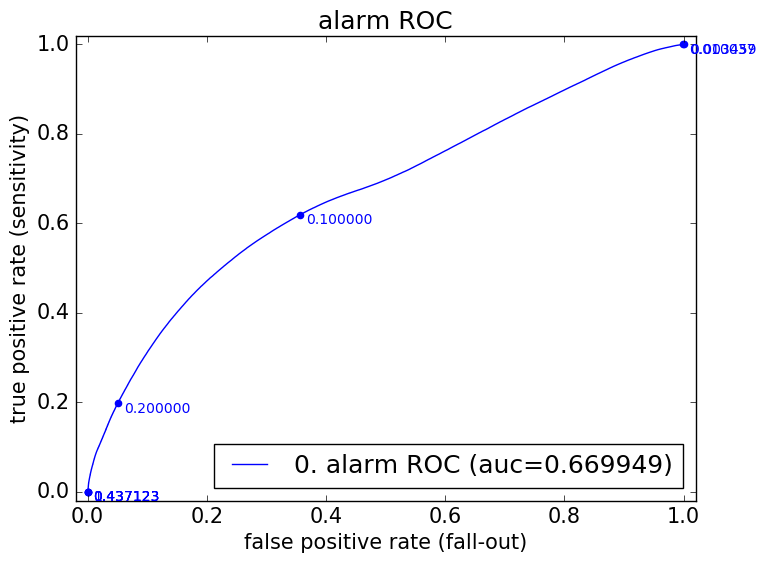

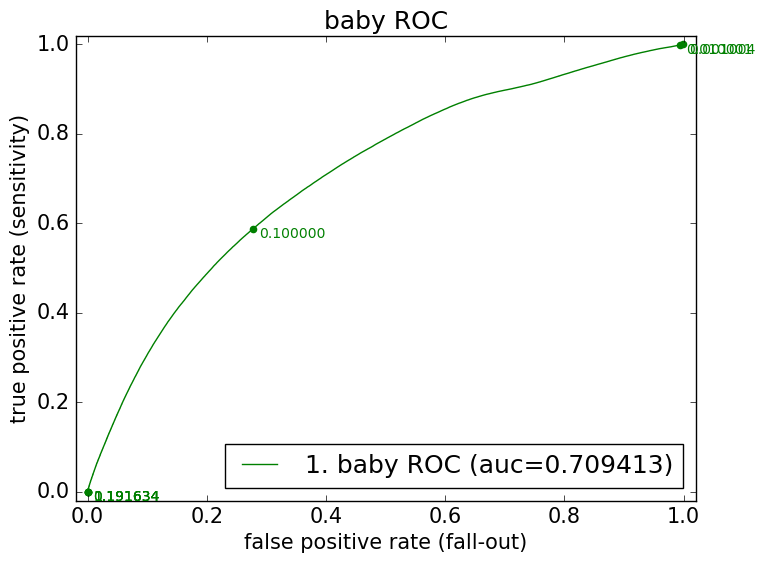

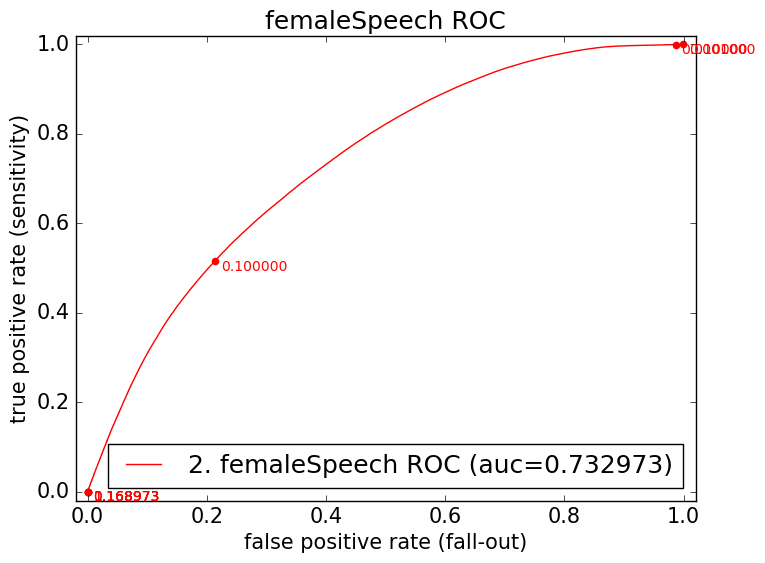

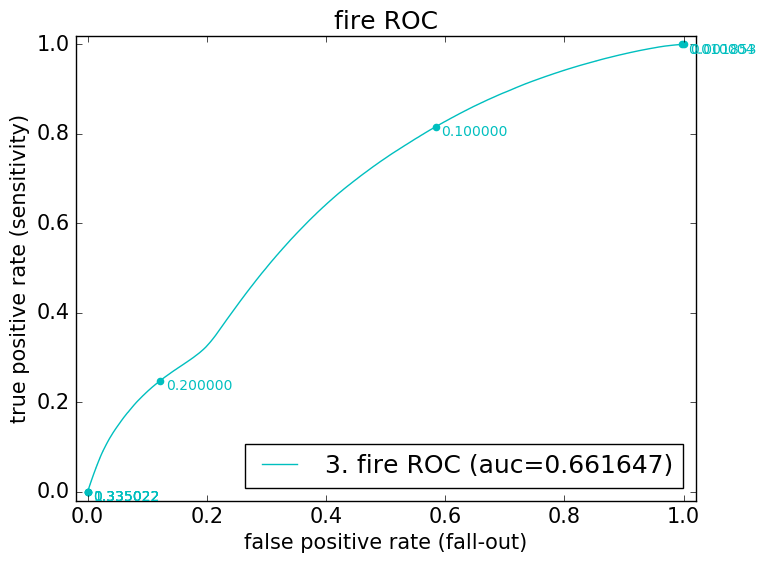

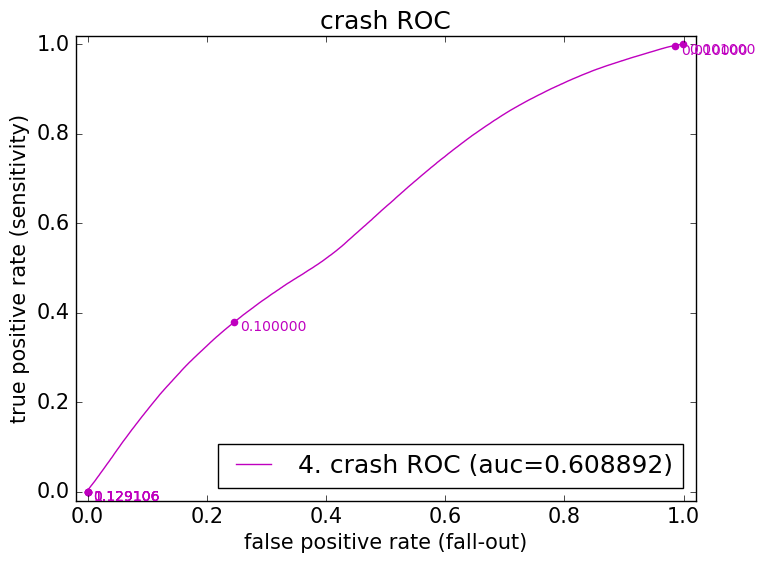

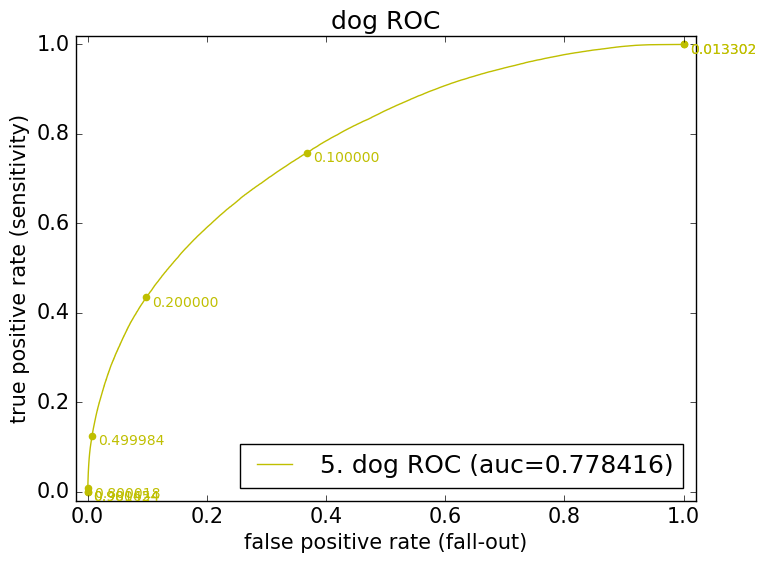

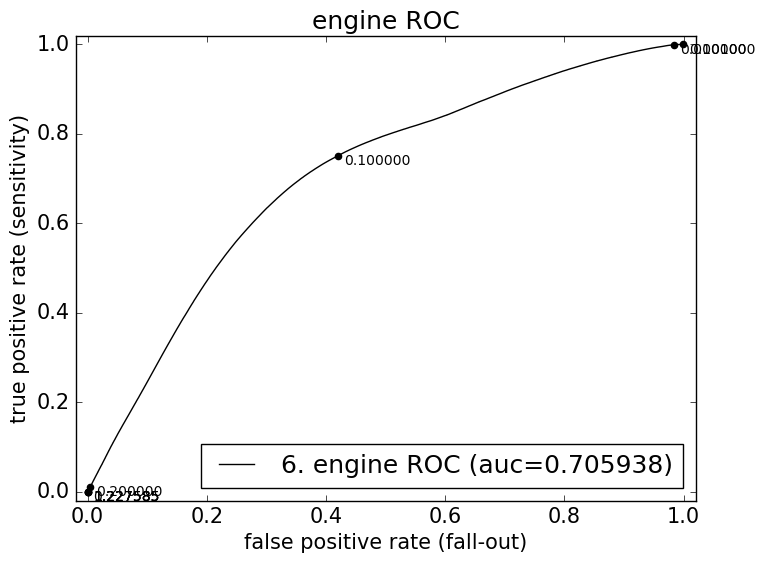

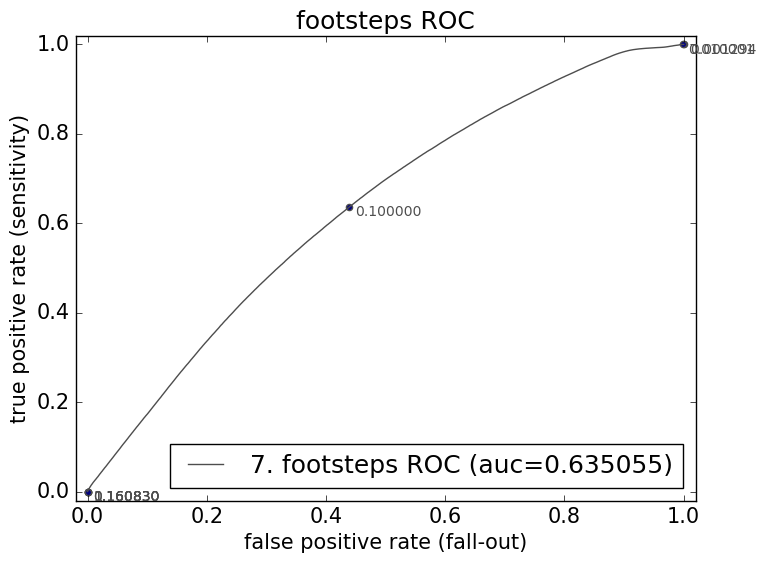

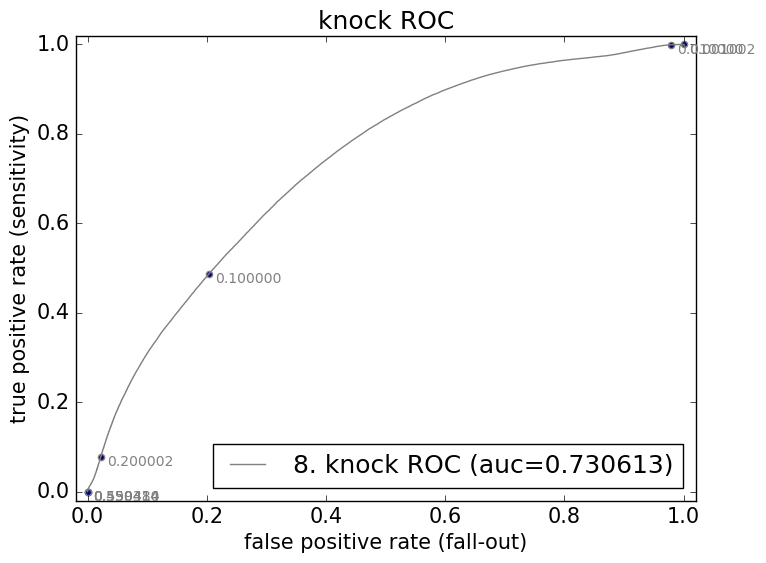

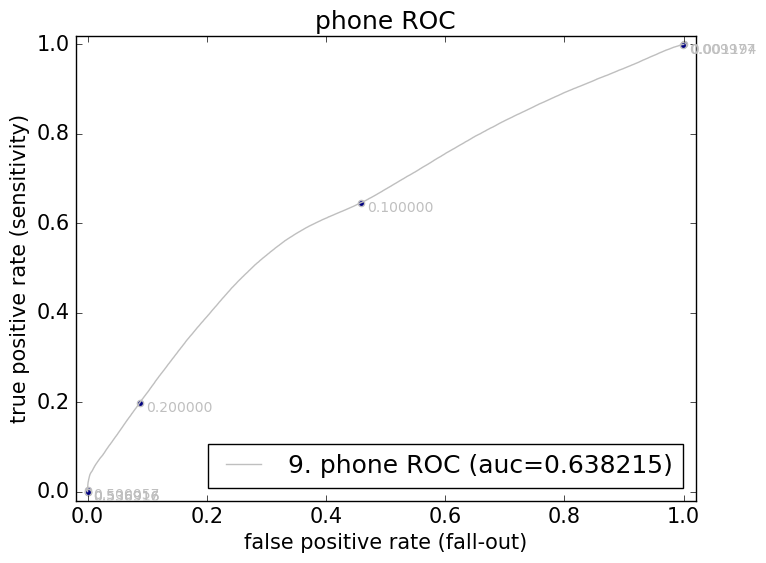

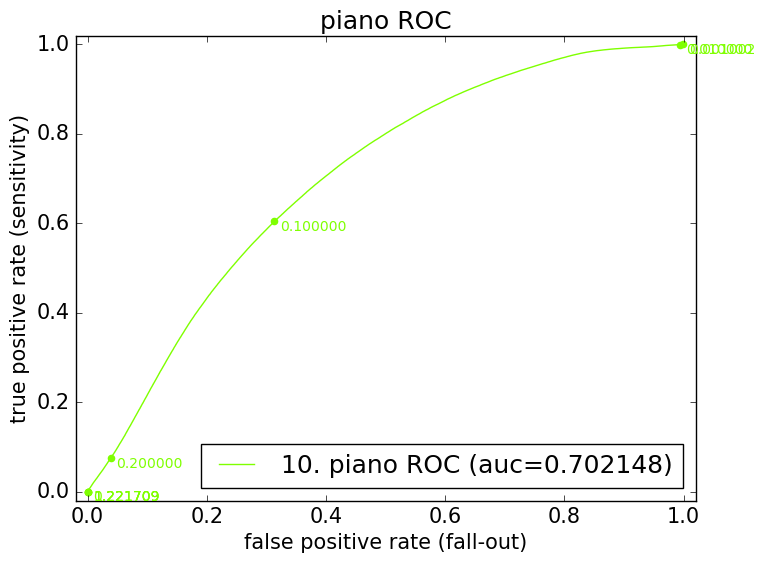

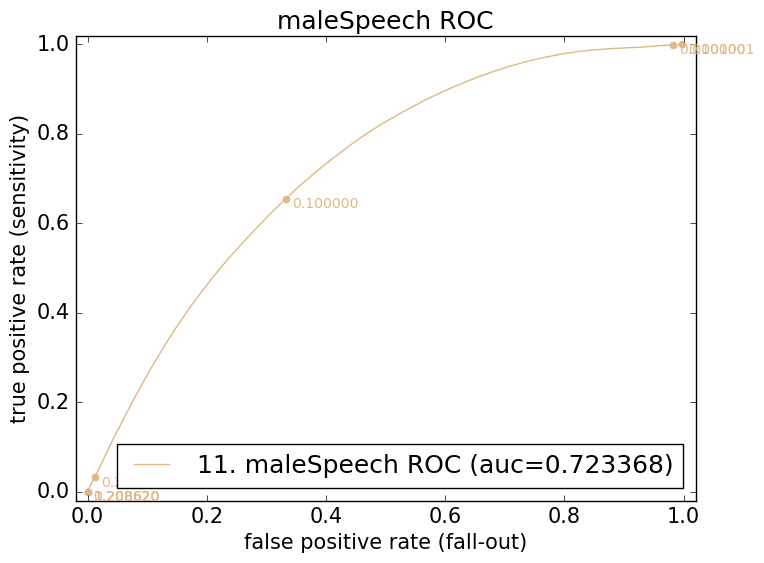

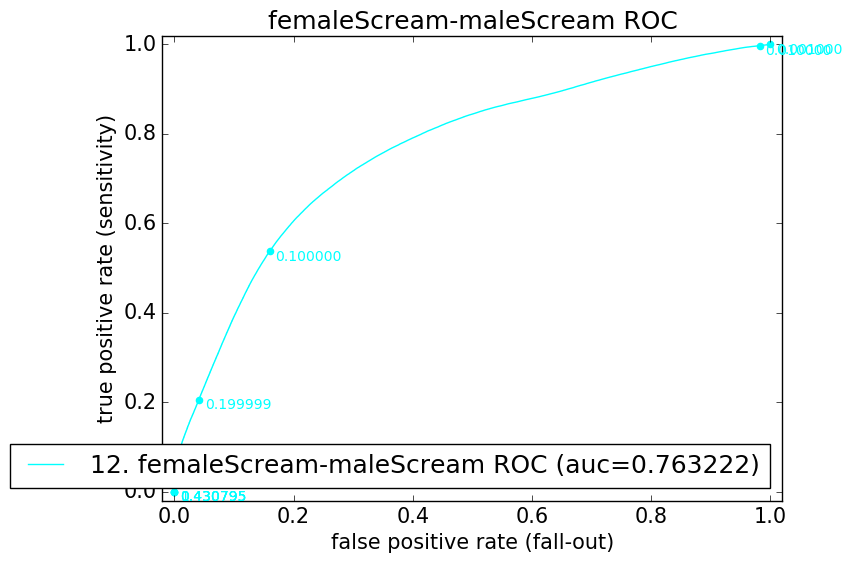

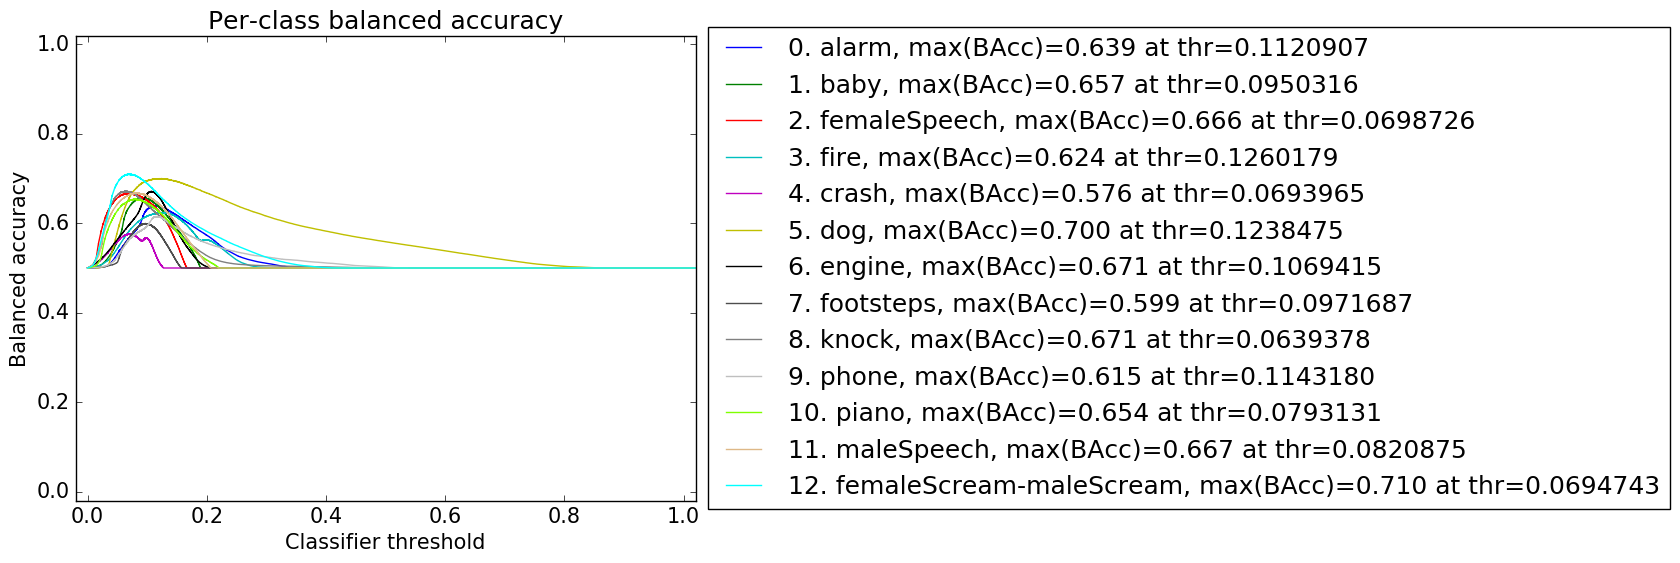

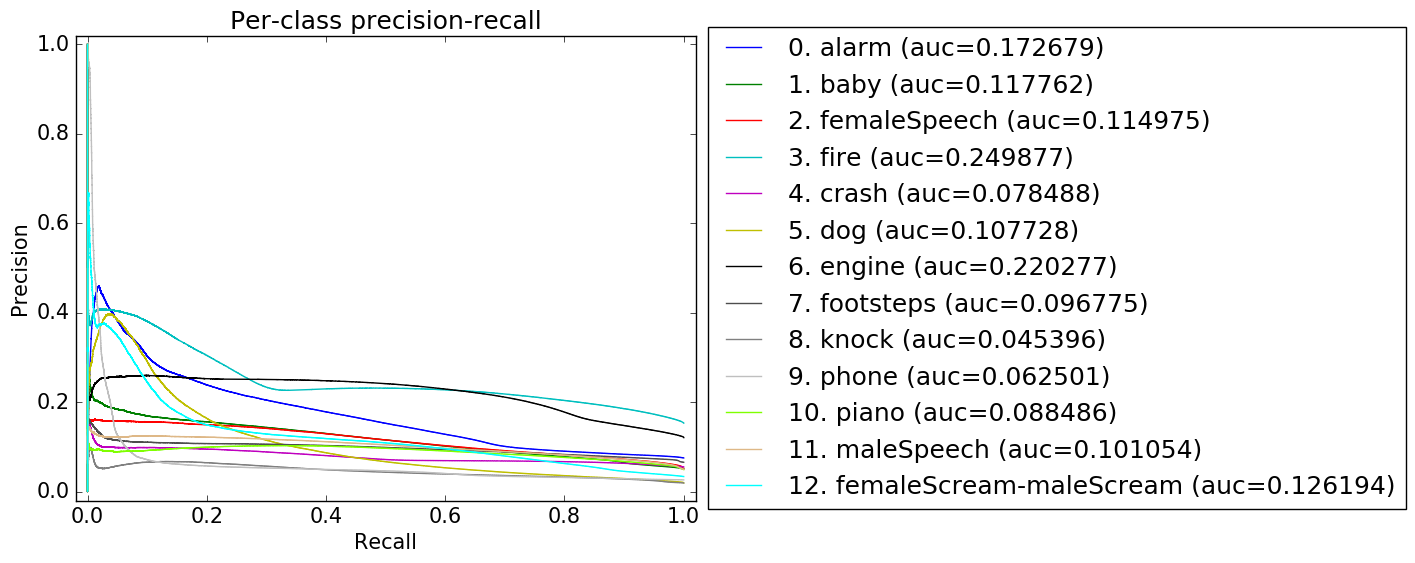

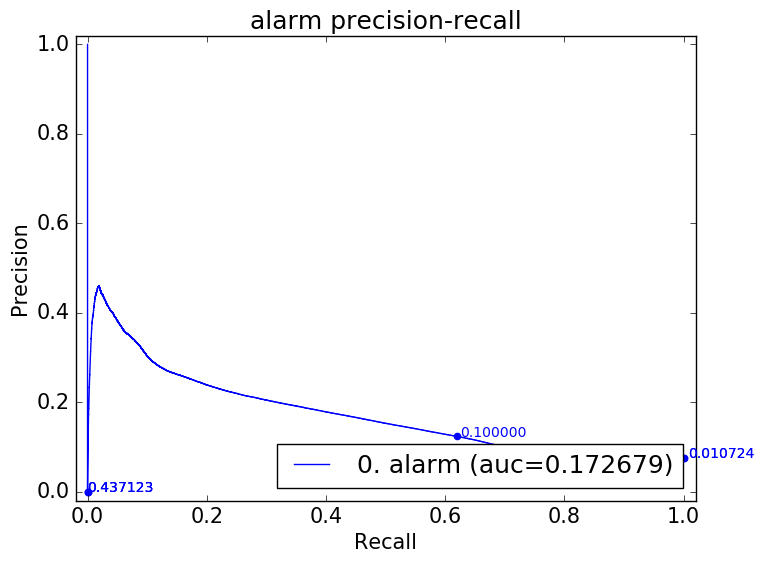

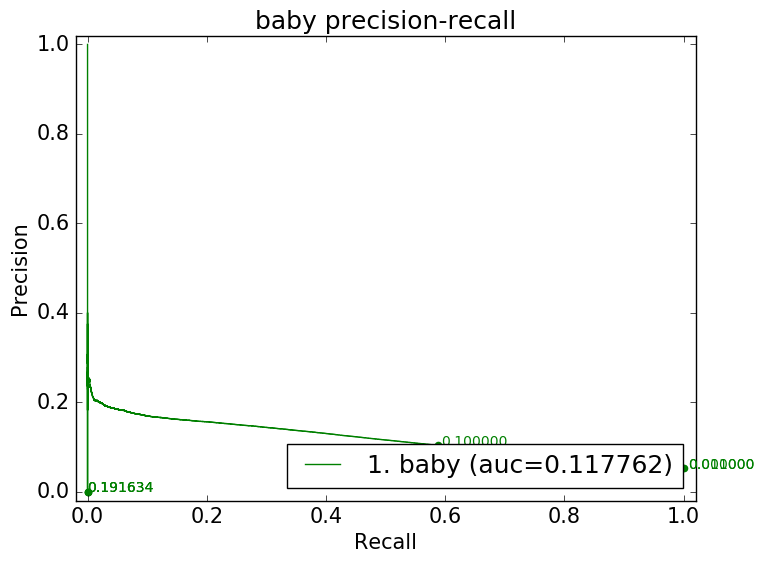

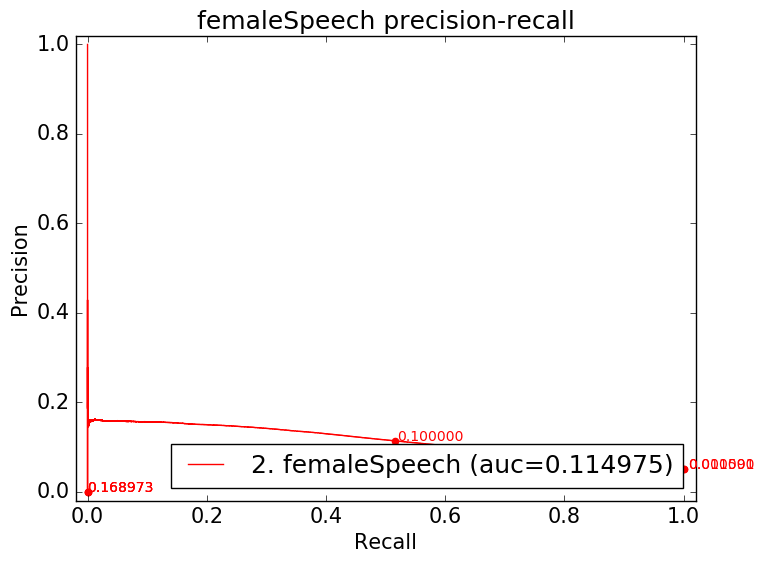

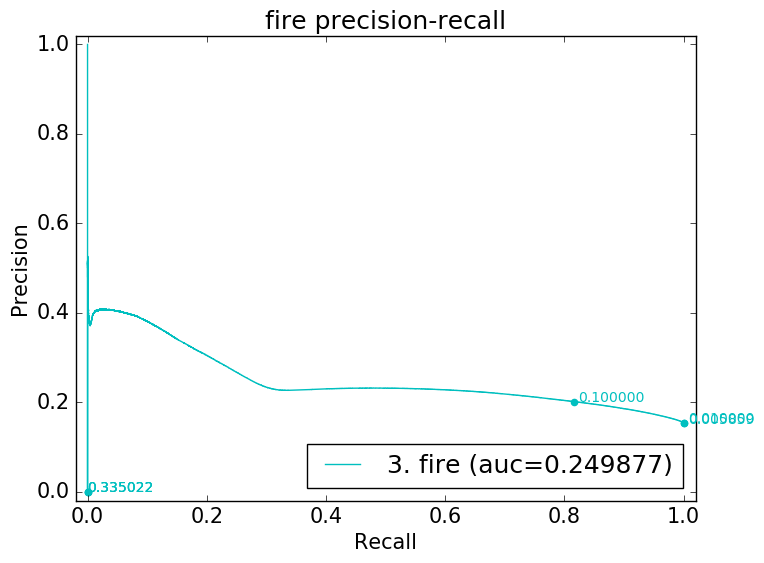

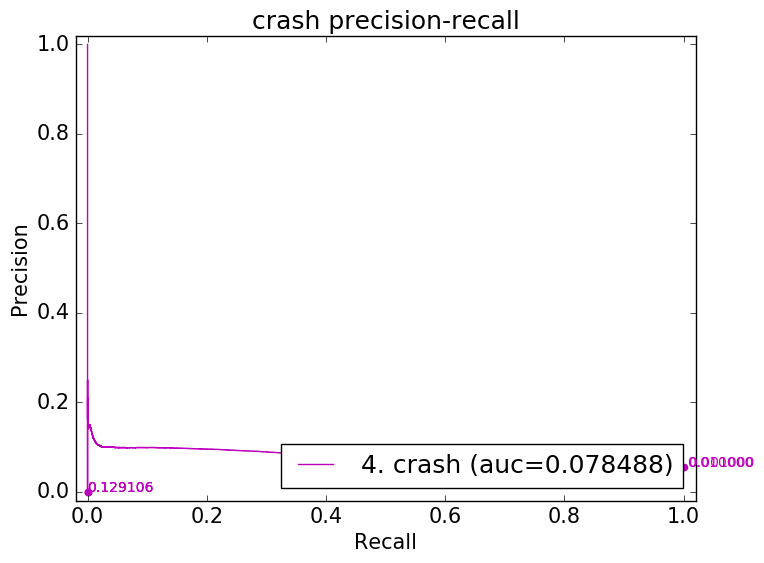

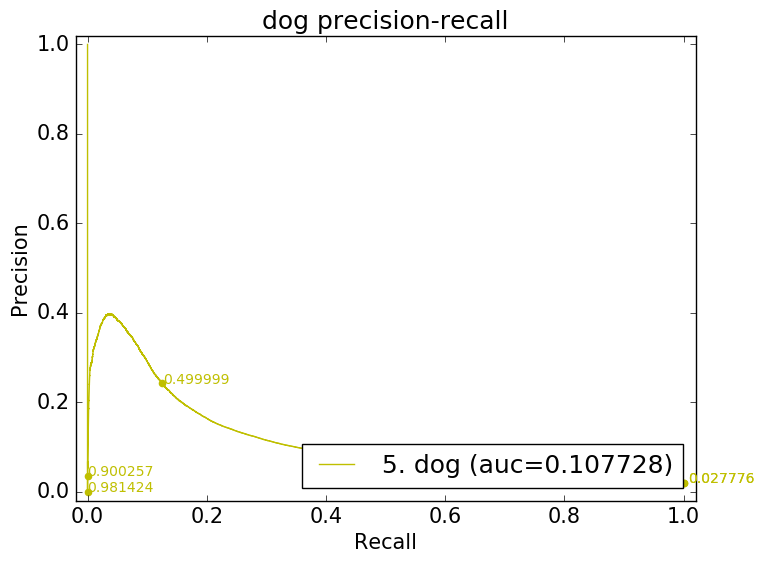

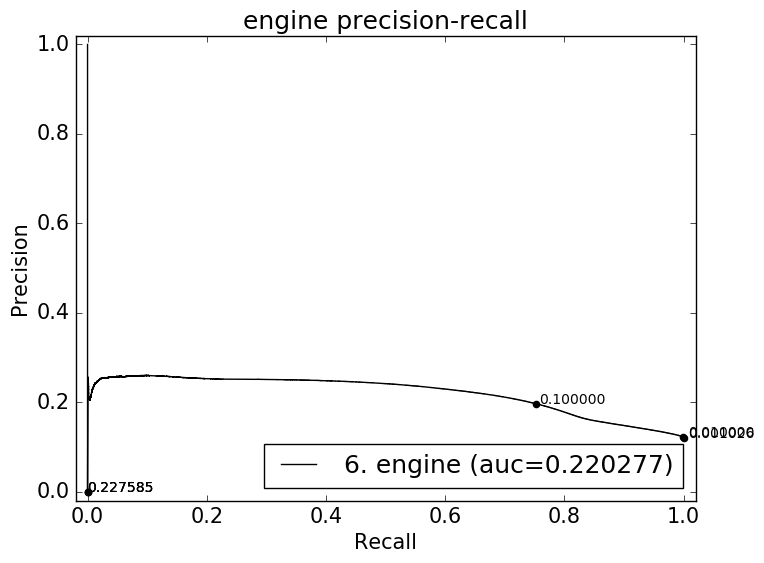

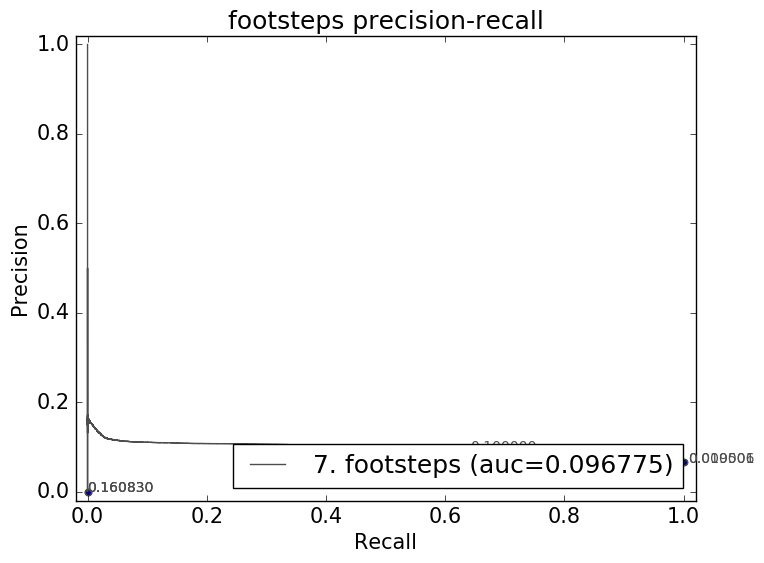

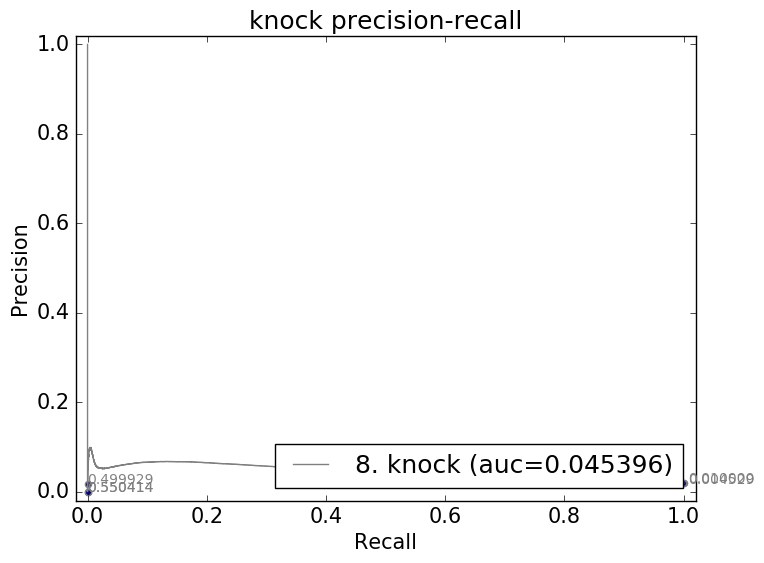

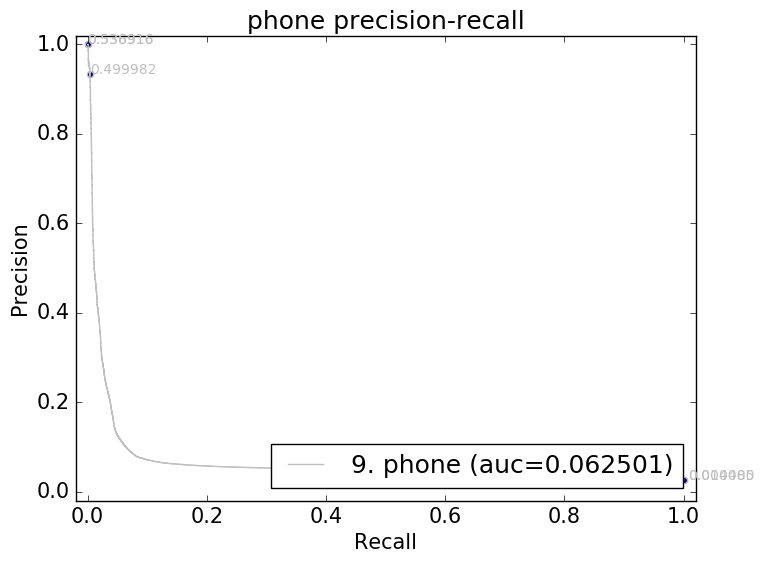

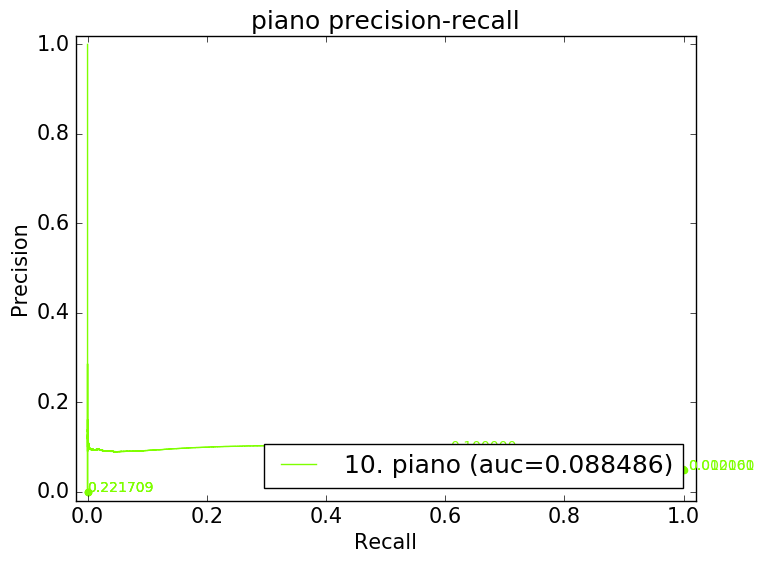

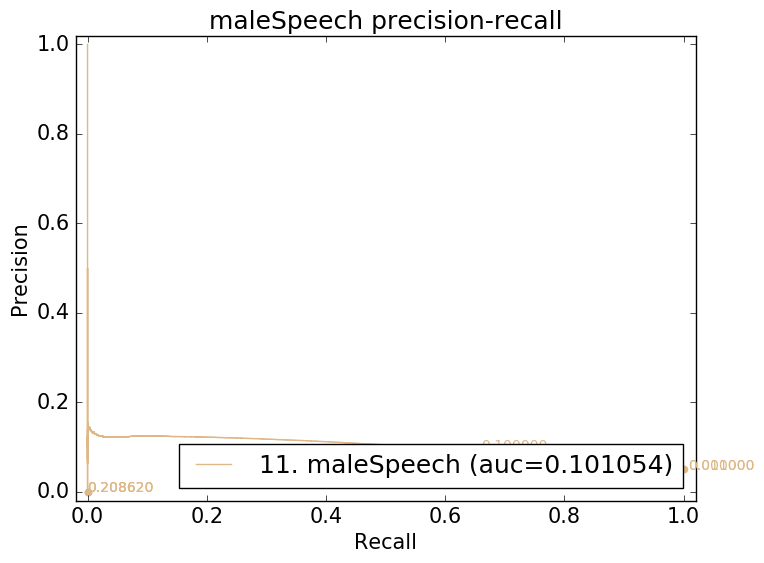

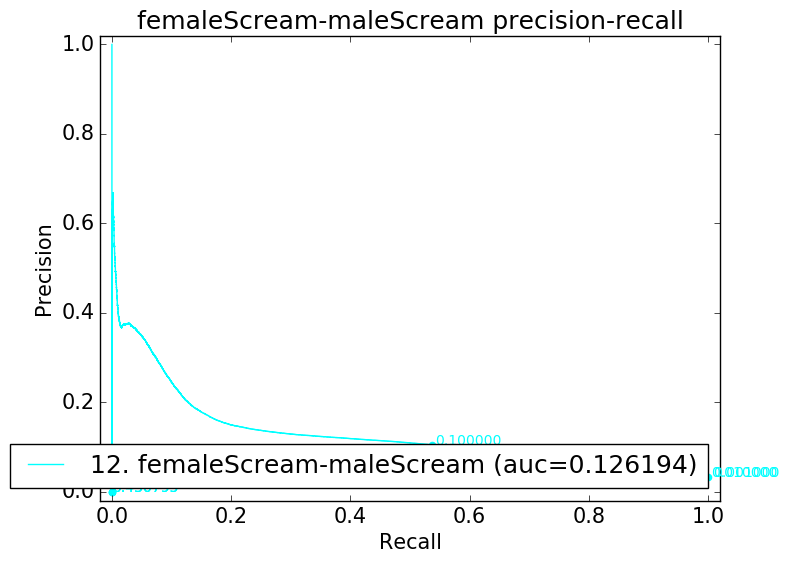

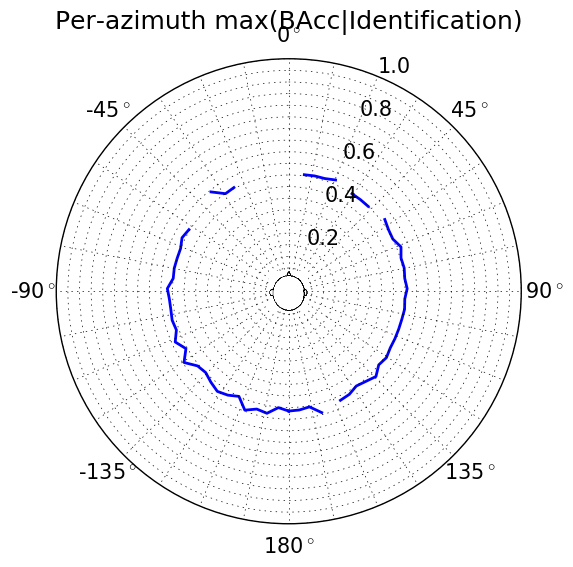

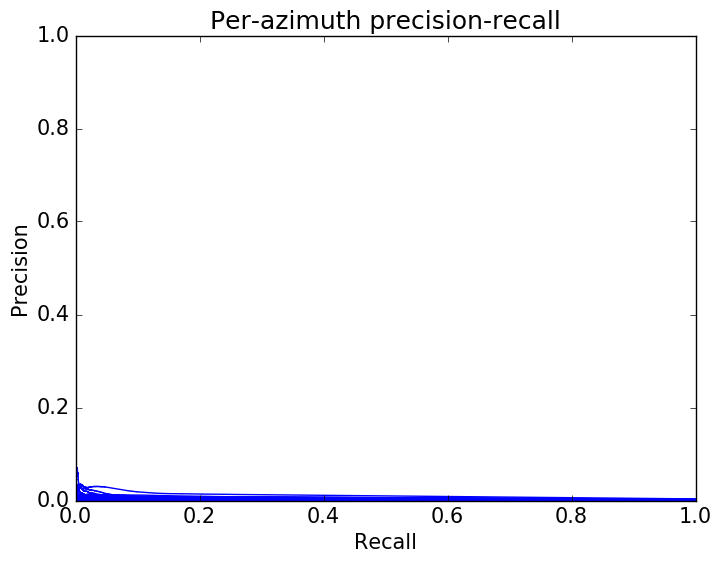

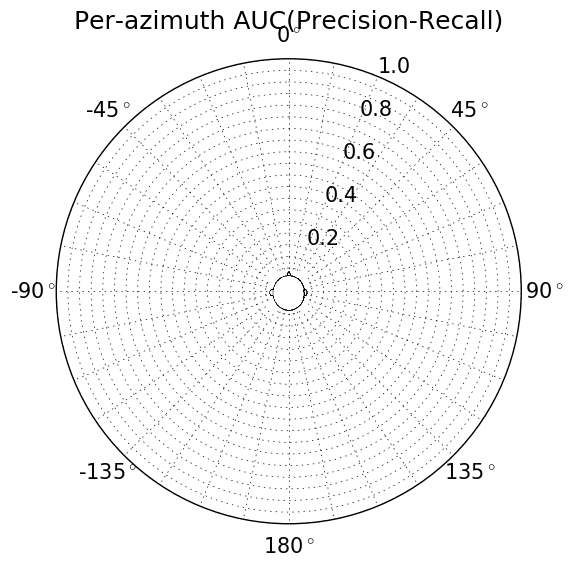

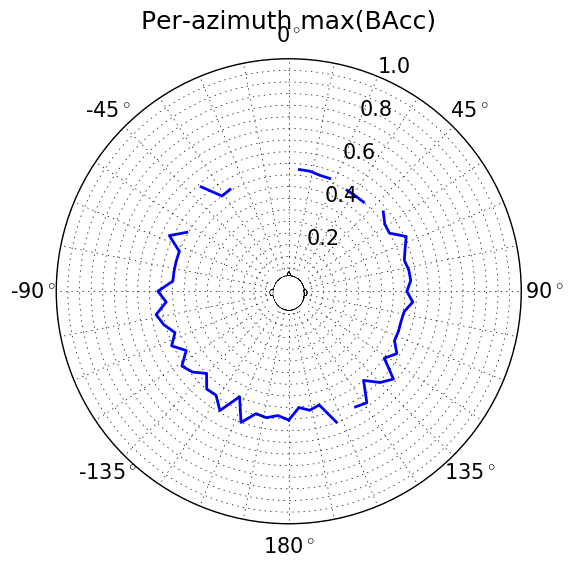

In [23]:
fpath = '/mnt/antares_raid/home/pierre/masterarbeit/caffe-datasets/models/best2/infer/best2_second2.h5'
es = eval_summary(fpath)

In [24]:
# Il faut enregistrer
#label_id_loc (4627800, 13, 1, 73)
#label_nSrcs (4627800, 1, 1, 1)
#sigmoid_id_loc_nidx_00_c_03_3 (4627800, 13, 1, 73)
#sigmoid_id_loc_nidx_01_c_03_4 (4627800, 13, 1, 73)

In [52]:
moyenne = 0
maxi = 0
for classname in es[0]['id_bacc']:
    if maxi < classname['bacc_cl_max']:
        print classname['classname']
    maxi = max(maxi, classname['bacc_cl_max'])
    moyenne += classname['bacc_cl_max']
print "moyenne:", moyenne / len(es[0]['id_bacc'])
print "max", maxi

alarm
baby
femaleSpeech
dog
femaleScream-maleScream
moyenne: 0.649836977337
max 0.709500255821


In [51]:
moyenne_bacc = 0
max_bacc = 0
count = 0
for angle in es[1]['loc_bacc']:
    if not math.isnan(angle['bacc_cl_max']):
        moyenne_bacc += angle['bacc_cl_max']
        if max_bacc < angle['bacc_cl_max']:
            print angle['classname']
        max_bacc = max(max_bacc, angle['bacc_cl_max'])
        count += 1
    # print angle['classname'], angle['bacc_cl_max']
print "Moyenne:", moyenne_bacc / count
print "Max:", max_bacc

classname
num_points
bacc_cl_max
specificity_bacc_cl_max
cl_id
num_pos
thr_bacc_cl_max
sensitivity_bacc_cl_max
----------
femaleScream-maleScream
femaleScream-maleScream
Moyenne: 0.531518159531
Max: 0.600495428928


In [ ]:
print es[1].keys()
print "Id classes par ROC AUC", [(x['classname'], x['roc_auc']) for x in sorted(es[0]['id_roc'], key=lambda x: x['roc_auc'], reverse=True)]

print "Id classes par balanced accuracy", [(x['classname'], x['bacc_cl_max']) for x in sorted(es[0]['id_bacc'], key=lambda x: x['bacc_cl_max'], reverse=True)]